# LSH



Don't forget todownload the twitter samples and stopwords from nltk.

```
nltk.download('stopwords')
nltk.download('twitter_samples')
```

### This Notebook covers the folowing topics:

- [1. LSH and document search](#3)
  - [1.1 Getting the document embeddings](#3-1)    
  - [1.2 Looking up the tweets](#3-2)
  - [1.3 Finding the most similar tweets with LSH](#3-3)
  - [1.4 Getting the hash number for a vector](#3-4) 
  - [1.5 Creating a hash table](#3-5)
  - [1.6 Creating all hash tables](#3-6)
        

In [1]:
import pdb
import pickle
import string

import time

import gensim
import matplotlib.pyplot as pltyas
import nltk
import numpy as np
import scipy
import sklearn
from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer

#from utils import (cosine_similarity, get_dict,process_tweet)
from os import getcwd


Bad key savefig.frameon in file /home/abderrazak/Téléchargements/yes/envs/stuff/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/abderrazak/Téléchargements/yes/envs/stuff/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/abderrazak/Téléchargements/yes/envs/stuff/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout

In [2]:
nltk.download('stopwords')
nltk.download('twitter_samples')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abderrazak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/abderrazak/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
   <li> Useful functions:
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html">Numpy dot </a>,
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html">Numpy sum</a>,
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.square.html">Numpy square</a>,
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">Numpy norm</a>
    </li>
   <li> Be careful about which operation is elementwise and which operation is a matrix multiplication.</li>
   <li> Try to use matrix operations instead of the numpy norm function.  If you choose to use norm function, take care of extra arguments and that it's returning loss squared, and not the loss itself.</li>

</ul>
</p>

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
    <ul>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.T.html" > Transposing in numpy </a></li>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html" > Finding out the dimensions</a> of matrices in numpy </li>
    <li>Remember to use numpy.dot for matrix multiplication </li>
    </ul>
</p>
 

### Cosine similarity
Cosine similarity between vectors $u$ and $v$ calculated as the cosine of the angle between them.
The formula is 

$$\cos(u,v)=\frac{u\cdot v}{\left\|u\right\|\left\|v\right\|}$$

* $\cos(u,v)$ = $1$ when $u$ and $v$ lie on the same line and have the same direction.
* $\cos(u,v)$ is $-1$ when they have exactly opposite directions.
* $\cos(u,v)$ is $0$ when the vectors are orthogonal (perpendicular) to each other.

#### Note: Distance and similarity are pretty much opposite things.
* We can obtain distance metric from cosine similarity, but the cosine similarity can't be used directly as the distance metric. 
* When the cosine similarity increases (towards $1$), the "distance" between the two vectors decreases (towards $0$). 
* We can define the cosine distance between $u$ and $v$ as
$$d_{\text{cos}}(u,v)=1-\cos(u,v)$$

In [3]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    
    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot / (norma*normb)

   
    return cos

In [30]:
from datetime import datetime
import numpy as np

def timeit(func, iters, name):
    startTime = datetime.now() 
    for i in range(iters):
        func()
    print(name, datetime.now() - startTime)

print('100*1000, 100 loops')

timeit(lambda *a: np.linalg.norm(np.random.rand(100,1000), axis=1), 100, 'linalg')
timeit(lambda *a: np.sqrt(np.sum(np.random.rand(100,1000)**2, axis=1)), 100, 'sumosq')

print('100, 10000 loops')

timeit(lambda *a: np.linalg.norm(np.random.rand(100)), 10000, 'linalg')
timeit(lambda *a: np.sqrt(np.sum(np.random.rand(100)**2)), 10000, 'sumosq')

100*1000, 100 loops
linalg 0:00:00.078224
sumosq 0:00:00.063492
100, 10000 loops
linalg 0:00:00.048591
sumosq 0:00:00.086590


In [31]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    # you have to set this variable to the true label.
    cos = -10
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)

    return cos

<a name=""></a>

 `nearest_neighbor()`

Inputs:
* Vector `v`,
* A set of possible nearest neighbors `candidates`
* `k` nearest neighbors to find.
* The distance metric should be based on cosine similarity.
* `cosine_similarity` function is already implemented and imported for you. It's arguments are two vectors and it returns the cosine of the angle between them.
* Iterate over rows in `candidates`, and save the result of similarities between current row and vector `v` in a python list. Take care that similarities are in the same order as row vectors of `candidates`.
* Now you can use [numpy argsort]( https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html#numpy.argsort) to sort the indices for the rows of `candidates`.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> numpy.argsort sorts values from most negative to most positive (smallest to largest) </li>
    <li> The candidates that are nearest to 'v' should have the highest cosine similarity </li>
    <li> To get the last element of a list 'tmp', the notation is tmp[-1:] </li>
</ul>
</p>

In [4]:
def nearest_neighbor(v, candidates, k=1):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
  
    similarity_l = []

    # for each candidate vector...
    for row in candidates:
        # get the cosine similarity
        cos_similarity =cosine_similarity(v,row)

        # append the similarity to the list
        similarity_l.append(cos_similarity)
        
    # sort the similarity list and get the indices of the sorted list
    sorted_ids = np.argsort(similarity_l)

    # get the indices of the k most similar candidate vectors
    k_idx = sorted_ids[-k:]
    return k_idx


In [5]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Test your implementation:
v = np.array([1, 0, 1])
candidates = np.array([[1, 0, 5], [-2, 5, 3], [2, 0, 1], [6, -9, 5], [9, 9, 9]])
print(candidates[nearest_neighbor(v, candidates, 3)])

[[9 9 9]
 [1 0 5]
 [2 0 1]]


<a name=""></a>

#  LSH and document search

In this part , you will implement a more efficient version
of k-nearest neighbors using locality sensitive hashing.
You will then apply this to document search.

* Process the tweets and represent each tweet as a vector (represent a
document with a vector embedding).
* Use locality sensitive hashing and k nearest neighbors to find tweets
that are similar to a given tweet.

In [6]:
# get the positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

<a name=""></a>

###  Getting the document embeddings

#### Bag-of-words (BOW) document models
Text documents are sequences of words.
* The ordering of words makes a difference. For example, sentences "Apple pie is
better than pepperoni pizza." and "Pepperoni pizza is better than apple pie"
have opposite meanings due to the word ordering.
* However, for some applications, ignoring the order of words can allow
us to train an efficient and still effective model.
* This approach is called Bag-of-words document model.

#### Document embeddings
* Document embedding is created by summing up the embeddings of all words
in the document.
* If we don't know the embedding of some word, we can ignore that word.

<a name=""></a>
`get_document_embedding()` function.
* The function `get_document_embedding()` encodes entire document as a "document" embedding.
* It takes in a docoument (as a string) and a dictionary, `en_embeddings`
* It processes the document, and looks up the corresponding embedding of each word.
* It then sums them up and returns the sum of all word vectors of that processed tweet.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> You can handle missing words easier by using the `get()` method of the python dictionary instead of the bracket notation (i.e. "[ ]"). See more about it <a href="https://stackoverflow.com/a/11041421/12816433" >here</a> </li>
    <li> The default value for missing word should be the zero vector. Numpy will <a href="https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html" > broadcast </a> simple 0 scalar into a vector of zeros during the summation.</li>
    <li>Alternatively, skip the addition if a word is not in the dictonary. </li>
    <li>  You can use your `process_tweet()` function which allows you to process the tweet. The function just takes in a tweet and returns a list of words.</li>
</ul>
</p>

In [20]:
import re
import string

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return ' '.join(tweets_clean)

In [21]:
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')
# process a sentence using the model
doc = nlp("This is some text that I am processing with Spacy")
# It's that simple - all of the vectors and words are assigned after this point
# Get the vector for 'text':
doc[3].vector
# Get the mean vector for the entire sentence (useful for sentence classification etc.)
doc.vector

array([-5.36412969e-02,  2.79353321e-01, -1.05259977e-01, -1.76284965e-02,
        1.34550199e-01,  1.92671806e-01,  5.50469756e-03, -2.39132687e-01,
       -4.06342074e-02,  1.78010297e+00, -1.80772960e-01,  1.02661893e-01,
        6.84069991e-02, -5.09319194e-02, -7.65837058e-02, -3.77540514e-02,
        8.24129581e-03,  1.37752008e+00, -1.78934380e-01, -5.76109104e-02,
        1.66338980e-02, -3.62196006e-02, -7.48579949e-02,  4.40651290e-02,
       -2.65241470e-02,  2.41529979e-02,  9.79370065e-03, -1.13990309e-03,
        1.59522101e-01, -1.56648397e-01, -9.12139937e-02,  9.11872908e-02,
        1.07169405e-01, -1.08843103e-01, -7.94988051e-02, -4.74919155e-02,
       -1.60613850e-01, -2.82304995e-02, -1.03425637e-01, -1.14933215e-01,
        1.62531182e-01, -1.01342008e-01,  2.17013666e-03,  3.47881988e-02,
       -6.34927005e-02,  2.44374484e-01, -3.01910043e-02, -1.46046979e-02,
       -1.06488302e-01,  6.26319647e-03, -1.30655810e-01,  7.04905912e-02,
       -4.86716032e-02,  

In [22]:
def get_document_embedding(tweet): 
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the tweet
    '''
    #doc_embedding = np.zeros(300)

    # process the document into a list of words (process the tweet)
    processed_doc = process_tweet(tweet)
    spacy_doc=nlp(processed_doc) 
    doc_embedding=spacy_doc.vector
    #for word in processed_doc:
        # add the word embedding to the running total for the document embedding
        #doc_embedding += en_embeddings.get(word,0)
    return doc_embedding

In [23]:
# testing your function
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
tweet_embedding = get_document_embedding(custom_tweet)
tweet_embedding[-5:]

array([-0.02576452,  0.23725046, -0.066124  , -0.2478355 ,  0.23242216],
      dtype=float32)

<a name=""></a>



#### Store all document vectors into a dictionary
Now, let's store all the tweet embeddings into a dictionary.
Implement `get_document_vecs()`

In [25]:
# UNQ_C14 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_document_vecs(all_docs):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''

    # the dictionary's key is an index (integer) that identifies a specific tweet
    # the value is the document embedding for that document
    ind2Doc_dict = {}

    # this is list that will store the document vectors
    document_vec_l = []

    for i, doc in enumerate(all_docs):

        
        # get the document embedding of the tweet
        doc_embedding = get_document_embedding(doc)

        # save the document embedding into the ind2Tweet dictionary at index i
        ind2Doc_dict[i] = doc_embedding

        # append the document embedding to the list of document vectors
        document_vec_l.append(doc_embedding)


    # convert the list of document vectors into a 2D array (each row is a document vector)
    document_vec_matrix = np.vstack(document_vec_l)
    
    return document_vec_matrix, ind2Doc_dict


In [26]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets)

In [27]:

# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 10000
shape of document_vecs (10000, 300)


<a name=""></a>

##  Looking up the tweets

Now you have a vector of dimension (m,d) where `m` is the number of tweets
(10,000) and `d` is the dimension of the embeddings (300).  Now you
will input a tweet, and use cosine similarity to see which tweet in our
corpus is similar to your tweet.

In [44]:
my_tweet = 'i am so cute '
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet)

In [45]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# this gives you a similar tweet as your input.
# this implementation is vectorized...
idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

@victoriaskyful @EXO_FANBASE he is being so damn cute :)


<a name=""></a>

##  Finding the most similar tweets with LSH

You will now implement locality sensitive hashing (LSH) to identify the most similar tweet.
* Instead of looking at all 10,000 vectors, you can just search a subset to find
its nearest neighbors.

Let's say your data points are plotted like this:

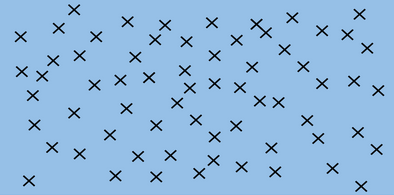


You can divide the vector space into regions and search within one region for nearest neighbors of a given vector.

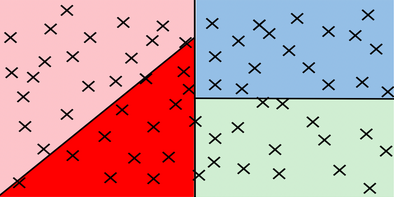

In [47]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

Number of vectors is 10000 and each has 300 dimensions.


#### Choosing the number of planes

* Each plane divides the space to $2$ parts.
* So $n$ planes divide the space into $2^{n}$ hash buckets.
* We want to organize 10,000 document vectors into buckets so that every bucket has about $~16$ vectors.
* For that we need $\frac{10000}{16}=625$ buckets.
* We're interested in $n$, number of planes, so that $2^{n}= 625$. Now, we can calculate $n=\log_{2}625 = 9.29 \approx 10$.

In [48]:
# The number of planes. We use log2(625) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

<a name=""></a>

##  Getting the hash number for a vector

For each vector, we need to get a unique number associated to that vector in order to assign it to a "hash bucket".

### Hyperlanes in vector spaces
* In $3$-dimensional vector space, the hyperplane is a regular plane. In $2$ dimensional vector space, the hyperplane is a line.
* Generally, the hyperplane is subspace which has dimension $1$ lower than the original vector space has.
* A hyperplane is uniquely defined by its normal vector.
* Normal vector $n$ of the plane $\pi$ is the vector to which all vectors in the plane $\pi$ are orthogonal (perpendicular in $3$ dimensional case).

### Using Hyperplanes to split the vector space
We can use a hyperplane to split the vector space into $2$ parts.
* All vectors whose dot product with a plane's normal vector is positive are on one side of the plane.
* All vectors whose dot product with the plane's normal vector is negative are on the other side of the plane.

### Encoding hash buckets
* For a vector, we can take its dot product with all the planes, then encode this information to assign the vector to a single hash bucket.
* When the vector is pointing to the opposite side of the hyperplane than normal, encode it by 0.
* Otherwise, if the vector is on the same side as the normal vector, encode it by 1.
* If you calculate the dot product with each plane in the same order for every vector, you've encoded each vector's unique hash ID as a binary number, like [0, 1, 1, ... 0].

<a name=""></a>

###  Implementing hash buckets

We've initialized hash table `hashes` for you. It is list of `N_UNIVERSES` matrices, each describes its own hash table. Each matrix has `N_DIMS` rows and `N_PLANES` columns. Every column of that matrix is a `N_DIMS`-dimensional normal vector for each of `N_PLANES` hyperplanes which are used for creating buckets of the particular hash table.

*Exercise*: Your task is to complete the function `hash_value_of_vector` which places vector `v` in the correct hash bucket.

* First multiply your vector `v`, with a corresponding plane. This will give you a vector of dimension $(1,\text{N_planes})$.
* You will then convert every element in that vector to 0 or 1.
* You create a hash vector by doing the following: if the element is negative, it becomes a 0, otherwise you change it to a 1.
* You then compute the unique number for the vector by iterating over `N_PLANES`
* Then you multiply $2^i$ times the corresponding bit (0 or 1).
* You will then store that sum in the variable `hash_value`.

**Intructions:** Create a hash for the vector in the function below.
Use this formula:

$$ hash = \sum_{i=0}^{N-1} \left( 2^{i} \times h_{i} \right) $$

#### Create the sets of planes
* Create multiple (25) sets of planes (the planes that divide up the region).
* You can think of these as 25 separate ways of dividing up the vector space with a different set of planes.
* Each element of this list contains a matrix with 300 rows (the word vector have 300 dimensions), and 10 columns (there are 10 planes in each "universe").

In [49]:
np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> numpy.squeeze() removes unused dimensions from an array; for instance, it converts a (10,1) 2D array into a (10,) 1D array</li>
</ul>
</p>

In [50]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    # for the set of planes,
    # calculate the dot product between the vector and the matrix containing the planes
    # remember that planes has shape (300, 10)
    # The dot product will have the shape (1,10)
    dot_product = np.dot(v,planes)
    
    # get the sign of the dot product (1,10) shaped vector
    sign_of_dot_product = np.sign(dot_product)
    
    # set h to be false (eqivalent to 0 when used in operations) if the sign is negative,
    # and true (equivalent to 1) if the sign is positive (1,10) shaped vector
    h = sign_of_dot_product>=0

    # remove extra un-used dimensions (convert this from a 2D to a 1D array)
    h = np.squeeze(h)

    # initialize the hash value to 0
    hash_value = 0

    n_planes = planes.shape[1]
    for i in range(n_planes):
        # increment the hash value by 2^i * h_i
        hash_value += np.power(2,i)*h[i]

    # cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

In [51]:
np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")

 The hash value for this vector, and the set of planes at index 0, is 768


##### Expected Output

```
The hash value for this vector, and the set of planes at index 0, is 768
```

<a name=""></a>

##  Creating a hash table

<a name=""></a>



Given that you have a unique number for each vector (or tweet), You now want to create a hash table. You need a hash table, so that given a hash_id, you can quickly look up the corresponding vectors. This allows you to reduce your search by a significant amount of time.
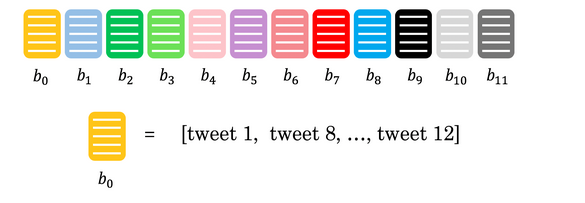

We have given you the `make_hash_table` function, which maps the tweet vectors to a bucket and stores the vector there. It returns the `hash_table` and the `id_table`. The `id_table` allows you know which vector in a certain bucket corresponds to what tweet.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> a dictionary comprehension, similar to a list comprehension, looks like this: `{i:0 for i in range(10)}`, where the key is 'i' and the value is zero for all key-value pairs. </li>
</ul>
</p>

In [53]:
# This is the code used to create a hash table
def make_hash_table(vecs, planes):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """

    # number of planes is the number of columns in the planes matrix
    num_of_planes = planes.shape[1]

    # number of buckets is 2^(number of planes)
    num_buckets = 2**num_of_planes

    # create the hash table as a dictionary.
    # Keys are integers (0,1,2.. number of buckets)
    # Values are empty lists
    hash_table = {i:[] for i in range(num_buckets)}

    # create the id table as a dictionary.
    # Keys are integers (0,1,2... number of buckets)
    # Values are empty lists
    id_table = {i:[] for i in range(num_buckets)}

    # for each vector in 'vecs'
    for i, v in enumerate(vecs):

        # calculate the hash value for the vector
        h = hash_value_of_vector(v,planes)
        #print(h)
        #print('******')
        # store the vector into hash_table at key h,
        # by appending the vector v to the list at key h
        hash_table[h].append(v)

        # store the vector's index 'i' (each document is given a unique integer 0,1,2...)
        # the key is the h, and the 'i' is appended to the list at key h
        id_table[h].append(i)

   

    return hash_table, id_table


In [54]:
np.random.seed(0)
planes = planes_l[0]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
tmp_hash_table, tmp_id_table = make_hash_table(document_vecs, planes)

print(f"The hash table at key 0 has {len(tmp_hash_table[0])} document vectors")
print(f"The id table at key 0 has {len(tmp_id_table[0])}")
print(f"The first 5 document indices stored at key 0 of are {tmp_id_table[0][0:5]}")

The hash table at key 0 has 1 document vectors
The id table at key 0 has 1
The first 5 document indices stored at key 0 of are [7284]


##### Expected output
```
The hash table at key 0 has 3 document vectors
The id table at key 0 has 3
The first 5 document indices stored at key 0 of are [3276, 3281, 3282]
```

<a name=""></a>

###  Creating all hash tables

You can now hash your vectors and store them in a hash table that
would allow you to quickly look up and search for similar vectors.
Run the cell below to create the hashes. By doing so, you end up having
several tables which have all the vectors. Given a vector, you then
identify the buckets in all the tables.  You can then iterate over the
buckets and consider much fewer vectors. The more buckets you use, the
more accurate your lookup will be, but also the longer it will take.

In [55]:
# Creating the hashtables
hash_tables = []
id_tables = []
for universe_id in range(N_UNIVERSES):  # there are 25 hashes
    print('working on hash universe #:', universe_id)
    planes = planes_l[universe_id]
    hash_table, id_table = make_hash_table(document_vecs, planes)
    hash_tables.append(hash_table)
    id_tables.append(id_table)

working on hash universe #: 0
working on hash universe #: 1
working on hash universe #: 2
working on hash universe #: 3
working on hash universe #: 4
working on hash universe #: 5
working on hash universe #: 6
working on hash universe #: 7
working on hash universe #: 8
working on hash universe #: 9
working on hash universe #: 10
working on hash universe #: 11
working on hash universe #: 12
working on hash universe #: 13
working on hash universe #: 14
working on hash universe #: 15
working on hash universe #: 16
working on hash universe #: 17
working on hash universe #: 18
working on hash universe #: 19
working on hash universe #: 20
working on hash universe #: 21
working on hash universe #: 22
working on hash universe #: 23
working on hash universe #: 24


### Approximate K-NN

<a name=""></a>


Implement approximate K nearest neighbors using locality sensitive hashing,
to search for documents that are similar to a given document at the
index `doc_id`.

##### Inputs
* `doc_id` is the index into the document list `all_tweets`.
* `v` is the document vector for the tweet in `all_tweets` at index `doc_id`.
* `planes_l` is the list of planes (the global variable created earlier).
* `k` is the number of nearest neighbors to search for.
* `num_universes_to_use`: to save time, we can use fewer than the total
number of available universes.  By default, it's set to `N_UNIVERSES`,
which is $25$ for this assignment.

The `approximate_knn` function finds a subset of candidate vectors that
are in the same "hash bucket" as the input vector 'v'.  Then it performs
the usual k-nearest neighbors search on this subset (instead of searching
through all 10,000 tweets).

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> There are many dictionaries used in this function.  Try to print out planes_l, hash_tables, id_tables to understand how they are structured, what the keys represent, and what the values contain.</li>
    <li> To remove an item from a list, use `.remove()` </li>
    <li> To append to a list, use `.append()` </li>
    <li> To add to a set, use `.add()` </li>
</ul>
</p>

In [59]:
# This is the code used to do the fast nearest neighbor search. Feel free to go over it
def approximate_knn(doc_id, v, planes_l, k=1, num_universes_to_use=N_UNIVERSES):
    """Search for k-NN using hashes."""
    assert num_universes_to_use <= N_UNIVERSES

    # Vectors that will be checked as p0ossible nearest neighbor
    vecs_to_consider_l = list()

    # list of document IDs
    ids_to_consider_l = list()

    # create a set for ids to consider, for faster checking if a document ID already exists in the set
    ids_to_consider_set = set()

    # loop through the universes of planes
    for universe_id in range(num_universes_to_use):

        # get the set of planes from the planes_l list, for this particular universe_id
        planes = planes_l[universe_id]

        # get the hash value of the vector for this set of planes
        hash_value = hash_value_of_vector(v, planes)

        # get the hash table for this particular universe_id
        hash_table = hash_tables[universe_id]

        # get the list of document vectors for this hash table, where the key is the hash_value
        document_vectors_l = hash_table[hash_value]

        # get the id_table for this particular universe_id
        id_table = id_tables[universe_id]

        # get the subset of documents to consider as nearest neighbors from this id_table dictionary
        new_ids_to_consider = id_table[hash_value]

        # remove the id of the document that we're searching
        if doc_id in new_ids_to_consider:
            new_ids_to_consider.remove(doc_id)
            print(f"removed doc_id {doc_id} of input vector from new_ids_to_search")

        # loop through the subset of document vectors to consider
        for i, new_id in enumerate(new_ids_to_consider):

            # if the document ID is not yet in the set ids_to_consider...
            if new_id not in ids_to_consider_set:
                # access document_vectors_l list at index i to get the embedding
                # then append it to the list of vectors to consider as possible nearest neighbors
                document_vector_at_i = document_vectors_l[i]
                

                # append the new_id (the index for the document) to the list of ids to consider
                vecs_to_consider_l.append(document_vector_at_i)
                ids_to_consider_l.append(new_id)
                # also add the new_id to the set of ids to consider
                # (use this to check if new_id is not already in the IDs to consider)
                ids_to_consider_set.add(new_id)

       

    # Now run k-NN on the smaller set of vecs-to-consider.
    print("Fast considering %d vecs" % len(vecs_to_consider_l))

    # convert the vecs to consider set to a list, then to a numpy array
    vecs_to_consider_arr = np.array(vecs_to_consider_l)

    # call nearest neighbors on the reduced list of candidate vectors
    nearest_neighbor_idx_l = nearest_neighbor(v, vecs_to_consider_arr, k=k)
    print(nearest_neighbor_idx_l)
    print(ids_to_consider_l)
    # Use the nearest neighbor index list as indices into the ids to consider
    # create a list of nearest neighbors by the document ids
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids


In [60]:
#document_vecs, ind2Tweet
doc_id = 0
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]

In [61]:
# Sample
nearest_neighbor_ids = approximate_knn(
    doc_id, vec_to_search, planes_l, k=3, num_universes_to_use=5)

Fast considering 922 vecs
[889 628   0]
[51, 71, 105, 154, 169, 193, 195, 251, 253, 310, 341, 535, 555, 866, 912, 933, 952, 1102, 1128, 1240, 1813, 2046, 2225, 2290, 2299, 2321, 2498, 2709, 2746, 2788, 2823, 2849, 2922, 3227, 3343, 3449, 3457, 3487, 3741, 4109, 4173, 4260, 4427, 4653, 5081, 5185, 5387, 5507, 6015, 6022, 6178, 6498, 6551, 6592, 6616, 6667, 6707, 7322, 7362, 7408, 7721, 8121, 8280, 8458, 8562, 8713, 9117, 9321, 9377, 9489, 9642, 7, 13, 20, 21, 36, 47, 49, 77, 80, 82, 86, 91, 119, 126, 127, 132, 135, 142, 153, 155, 172, 184, 192, 214, 219, 223, 232, 237, 241, 257, 269, 275, 277, 295, 330, 331, 336, 342, 344, 346, 360, 381, 383, 390, 414, 420, 441, 462, 472, 479, 481, 489, 490, 530, 538, 539, 551, 556, 567, 590, 615, 623, 625, 631, 645, 649, 682, 700, 706, 712, 726, 727, 788, 791, 807, 816, 827, 859, 870, 872, 897, 927, 932, 947, 963, 983, 1002, 1044, 1051, 1053, 1054, 1087, 1116, 1133, 1148, 1150, 1153, 1160, 1279, 1281, 1311, 1314, 1333, 1334, 1337, 1351, 1388, 1397, 140

In [62]:
print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_tweets[neighbor_id]}")

Nearest neighbors for document 0
Document contents: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

Nearest neighbor at document id 272
document contents: #FollowFriday @StayfanChemin @CCI_75 @aandreup for being top influencers in my community this week :)
Nearest neighbor at document id 216
document contents: @suzannepanter @kevinbacon @katosman Ah! Now it makes sense... Didn't see the pic on my effing phone last night. Woot :) x
Nearest neighbor at document id 51
document contents: #FollowFriday @France_Espana @reglisse_menthe @CCI_inter for being top engaged members in my community this week :)


# Conclusion
Now you can look up vectors that are similar to the encoding of your tweet using LSH!